In [1]:
# Dataset description

# Dataset description

For this project I used a Spotify audio-features dataset of Taylor Swift songs.  
Each row corresponds to a single track (including original albums, deluxe editions, live versions, and Taylor’s Version re‑recordings). After cleaning, the data contains the following variables:
NOTE: I have removed some tracks from the discography observed here because I do not personally consider them apart of her discography. For example, The Reputation Stadium Tour Surprise Song Playlist creates 
doubles of preexisting songs, that appear in the data as superrr low streams even though they are not stand alone actually released songs, and just throw off the data. These songs are from other earlier albums, 
so I removed them because I felt they just cluttered the data and were insignificant. 
I ultimately removed:
Reputation Stadium Tour Suprise Songs
Speak Now World Tour Live
Live From Clear Channel Stripped 2008 
Fearless (International Version)

| Variable       | Type    | Description |
|----------------|---------|------------|
| `track_name`   | character | Song title. |
| `album_name`   | character | Original album/edition name as listed in the CSV. |
| `album_group`  | character | Collapsed album label: deluxe/alternate versions are grouped under a main album title, but each “Taylor’s Version” album (e.g. `Red (Taylor's Version)`) is kept as its own group. |
| `release_date` | date      | Release date of the track on Spotify (YYYY‑MM‑DD). |
| `track_number` | numeric   | Track position within the album. |
| `id`           | character | Spotify track ID. |
| `uri`          | character | Spotify track URI. |
| `acousticness` | numeric   | 0–1; higher values indicate more acoustic tracks. |
| `danceability` | numeric   | 0–1; how suitable a track is for dancing (tempo, rhythm stability, beat strength, etc.). |
| `energy`       | numeric   | 0–1; intensity and activity (loud, fast, noisy vs calm). |
| `instrumentalness` | numeric | 0–1; probability that the track is mostly instrumental (higher = fewer vocals). |
| `liveness`     | numeric   | 0–1; higher values indicate a stronger live‑performance feel. |
| `loudness`     | numeric   | Average loudness in dB (typically negative; closer to 0 = louder). |
| `speechiness`  | numeric   | 0–1; presence of spoken words/rap. |
| `tempo`        | numeric   | Estimated tempo in beats per minute (BPM). |
| `valence`      | numeric   | 0–1; musical “positiveness” (happy/cheerful vs sad/angry). |
| `popularity`   | numeric   | Spotify popularity score (0–100), where higher values indicate more popular tracks. |
| `duration_ms`  | numeric   | Track duration in milliseconds. |
| `bw_album`     | factor    | Album aesthetic: `black_white` for folklore / reputation / THE TORTURED POETS DEPARTMENT, otherwise `color`. |
| `pop_group`    | factor    | Popularity group based on quartiles: `low`, `medium`, or `high`. |

ERROR: Error in parse(text = x, srcfile = src): <text>:3:5: unexpected symbol
2: 
3: For this
       ^


In [27]:
#packages

library(readr)
library(tidyverse)
library(glmnet)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ purrr     1.0.1
✔ forcats   1.0.0     ✔ tibble    3.2.1
✔ ggplot2   3.4.2     ✔ tidyr     1.3.0
✔ lubridate 1.9.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-7



In [28]:
#cleaning data

ts_raw <- read_csv("taylor_swift_spotify.csv", show_col_types = FALSE)

ts <- ts_raw |>
  distinct(id, .keep_all = TRUE) |>                      
  select(-any_of(c("Unnamed: 0", "...1"))) |>            
  rename(
    track_name = name,
    album_name = album
  ) |>
  mutate(
    release_date = as.Date(release_date),

    # album_group: collapse deluxe/alternate versions to a main title,
    # but keep all Taylor's Version albums separate
    album_group = case_when(
      # Taylor's Version groups (keep separate)
      str_detect(album_name, "1989 \\(Taylor's Version")   ~ "1989 (Taylor's Version)",
      str_detect(album_name, "Fearless \\(Taylor's Version") ~ "Fearless (Taylor's Version)",
      str_detect(album_name, "Speak Now \\(Taylor's Version") ~ "Speak Now (Taylor's Version)",
      str_detect(album_name, "Red \\(Taylor's Version")      ~ "Red (Taylor's Version)",

      # Non-TV albums: group variants under main title
      album_name %in% c("1989", "1989 (Deluxe)") ~ "1989",
      album_name %in% c("Fearless (International Version)", "Fearless (Platinum Edition)") ~ "Fearless",
      album_name %in% c("Speak Now", "Speak Now (Deluxe Package)", "Speak Now World Tour Live") ~ "Speak Now",
      album_name %in% c("Red", "Red (Deluxe Edition)") ~ "Red",
      album_name %in% c("Midnights", "Midnights (3am Edition)", "Midnights (The Til Dawn Edition)") ~ "Midnights",
      album_name %in% c("evermore", "evermore (deluxe version)") ~ "evermore",
      album_name %in% c(
        "folklore",
        "folklore (deluxe version)",
        "folklore: the long pond studio sessions (from the Disney+ special) [deluxe edition]"
      ) ~ "folklore",
      album_name %in% c("reputation", "reputation Stadium Tour Surprise Song Playlist") ~ "reputation",
      album_name %in% c(
        "THE TORTURED POETS DEPARTMENT",
        "THE TORTURED POETS DEPARTMENT: THE ANTHOLOGY"
      ) ~ "THE TORTURED POETS DEPARTMENT",
      album_name %in% c("Taylor Swift (Deluxe Edition)", "Live From Clear Channel Stripped 2008") ~ "Taylor Swift",
      album_name == "Lover" ~ "Lover",
      TRUE ~ album_name
    ),

    # black/white vs color albums based on grouped album
    bw_album = case_when(
      album_group %in% c("folklore", "reputation", "THE TORTURED POETS DEPARTMENT") ~ "black_white",
      TRUE ~ "color"
    ),
    bw_album = factor(bw_album, levels = c("color", "black_white"))
  )

# audio feature columns used throughout
audio_vars <- c(
  "acousticness", "danceability", "energy", "instrumentalness",
  "liveness", "loudness", "speechiness", "tempo", "valence"
)

# drop rows with missing audio features or popularity (if any)
ts <- ts |>
  drop_na(all_of(c(audio_vars, "popularity")))

# popularity quartiles and groups
p25 <- quantile(ts$popularity, 0.25, na.rm = TRUE)
p75 <- quantile(ts$popularity, 0.75, na.rm = TRUE)

ts <- ts |>
  mutate(
    pop_group = case_when(
      popularity <= p25 ~ "low",
      popularity >= p75 ~ "high",
      TRUE ~ "medium"
    ),
    pop_group = factor(pop_group, levels = c("low", "medium", "high"))
  )

# quick check
glimpse(ts)

New names:
• `` -> `...1`


Rows: 582
Columns: 20
$ track_name       <chr> "Fortnight (feat. Post Malone)", "The Tortured Poets …
$ album_name       <chr> "THE TORTURED POETS DEPARTMENT: THE ANTHOLOGY", "THE …
$ release_date     <date> 2024-04-19, 2024-04-19, 2024-04-19, 2024-04-19, 2024…
$ track_number     <dbl> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16…
$ id               <chr> "6dODwocEuGzHAavXqTbwHv", "4PdLaGZubp4lghChqp8erB", "…
$ uri              <chr> "spotify:track:6dODwocEuGzHAavXqTbwHv", "spotify:trac…
$ acousticness     <dbl> 0.5020, 0.0483, 0.1370, 0.5600, 0.7300, 0.3840, 0.624…
$ danceability     <dbl> 0.504, 0.604, 0.596, 0.541, 0.423, 0.521, 0.330, 0.53…
$ energy           <dbl> 0.386, 0.428, 0.563, 0.366, 0.533, 0.720, 0.483, 0.57…
$ instrumentalness <dbl> 1.53e-05, 0.00e+00, 0.00e+00, 1.00e-06, 2.64e-03, 0.0…
$ liveness         <dbl> 0.0961, 0.1260, 0.3020, 0.0946, 0.0816, 0.1350, 0.111…
$ loudness         <dbl> -10.976, -8.441, -7.362, -10.412, -11.388, -7.684, -9…
$ speechiness     

In [29]:
# codebook-summary

glimpse(ts)
summary(ts)


Rows: 582
Columns: 20
$ track_name       <chr> "Fortnight (feat. Post Malone)", "The Tortured Poets …
$ album_name       <chr> "THE TORTURED POETS DEPARTMENT: THE ANTHOLOGY", "THE …
$ release_date     <date> 2024-04-19, 2024-04-19, 2024-04-19, 2024-04-19, 2024…
$ track_number     <dbl> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16…
$ id               <chr> "6dODwocEuGzHAavXqTbwHv", "4PdLaGZubp4lghChqp8erB", "…
$ uri              <chr> "spotify:track:6dODwocEuGzHAavXqTbwHv", "spotify:trac…
$ acousticness     <dbl> 0.5020, 0.0483, 0.1370, 0.5600, 0.7300, 0.3840, 0.624…
$ danceability     <dbl> 0.504, 0.604, 0.596, 0.541, 0.423, 0.521, 0.330, 0.53…
$ energy           <dbl> 0.386, 0.428, 0.563, 0.366, 0.533, 0.720, 0.483, 0.57…
$ instrumentalness <dbl> 1.53e-05, 0.00e+00, 0.00e+00, 1.00e-06, 2.64e-03, 0.0…
$ liveness         <dbl> 0.0961, 0.1260, 0.3020, 0.0946, 0.0816, 0.1350, 0.111…
$ loudness         <dbl> -10.976, -8.441, -7.362, -10.412, -11.388, -7.684, -9…
$ speechiness     

  track_name         album_name         release_date         track_number  
 Length:582         Length:582         Min.   :2006-10-24   Min.   : 1.00  
 Class :character   Class :character   1st Qu.:2012-10-22   1st Qu.: 5.00  
 Mode  :character   Mode  :character   Median :2020-08-18   Median :10.00  
                                       Mean   :2018-04-17   Mean   :11.42  
                                       3rd Qu.:2022-10-22   3rd Qu.:15.00  
                                       Max.   :2024-04-19   Max.   :46.00  
      id                uri             acousticness       danceability   
 Length:582         Length:582         Min.   :0.000182   Min.   :0.1750  
 Class :character   Class :character   1st Qu.:0.037325   1st Qu.:0.5150  
 Mode  :character   Mode  :character   Median :0.184500   Median :0.5935  
                                       Mean   :0.333185   Mean   :0.5808  
                                       3rd Qu.:0.660000   3rd Qu.:0.6530  
                  

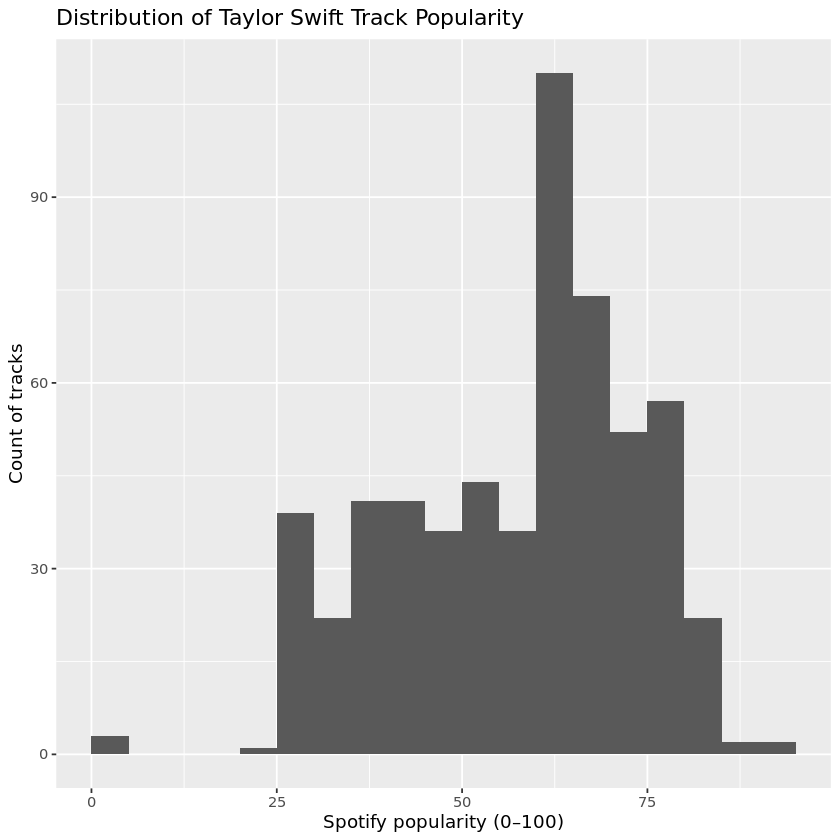

In [30]:
#popularity-distribution (Figure 1)

ts |>
  ggplot(aes(x = popularity)) +
  geom_histogram(binwidth = 5, boundary = 0) +
  labs(
    title = "Distribution of Taylor Swift Track Popularity",
    x = "Spotify popularity (0–100)",
    y = "Count of tracks"
  )

# Shows how Spotify popularity scores are spread across all songs. Most tracks sit in a mid-range (roughly 45–75), with a peak around 60–70 and relatively few songs at the very low or very high extremes, so the dataset is dominated by moderately popular songs.

In [31]:
# album-popularity-summary 

album_pop <- ts |>
  group_by(album_group) |>
  summarise(
    n_tracks = n(),
    mean_popularity = mean(popularity, na.rm = TRUE),
    median_popularity = median(popularity, na.rm = TRUE),
    .groups = "drop"
  ) |>
  arrange(desc(mean_popularity))

head(album_pop, 10)
tail(album_pop, 10)


album_group,n_tracks,mean_popularity,median_popularity
<chr>,<int>,<dbl>,<dbl>
THE TORTURED POETS DEPARTMENT,47,78.17021,78.0
Lover,18,75.94444,74.5
Speak Now (Taylor's Version),22,69.45455,69.0
1989 (Taylor's Version),43,67.48837,66.0
Red (Taylor's Version),30,67.23333,66.0
Midnights,56,65.30357,63.0
Fearless (Taylor's Version),26,65.26923,63.0
evermore,32,65.25000,64.0
folklore,67,59.01493,55.0


album_group,n_tracks,mean_popularity,median_popularity
<chr>,<int>,<dbl>,<dbl>
Midnights,56,65.30357,63.0
Fearless (Taylor's Version),26,65.26923,63.0
evermore,32,65.25000,64.0
folklore,67,59.01493,55.0
1989,32,50.50000,52.5
Taylor Swift,23,48.17391,54.0
Speak Now,52,46.82692,46.0
Red,38,44.97368,42.0
reputation,61,42.44262,31.0


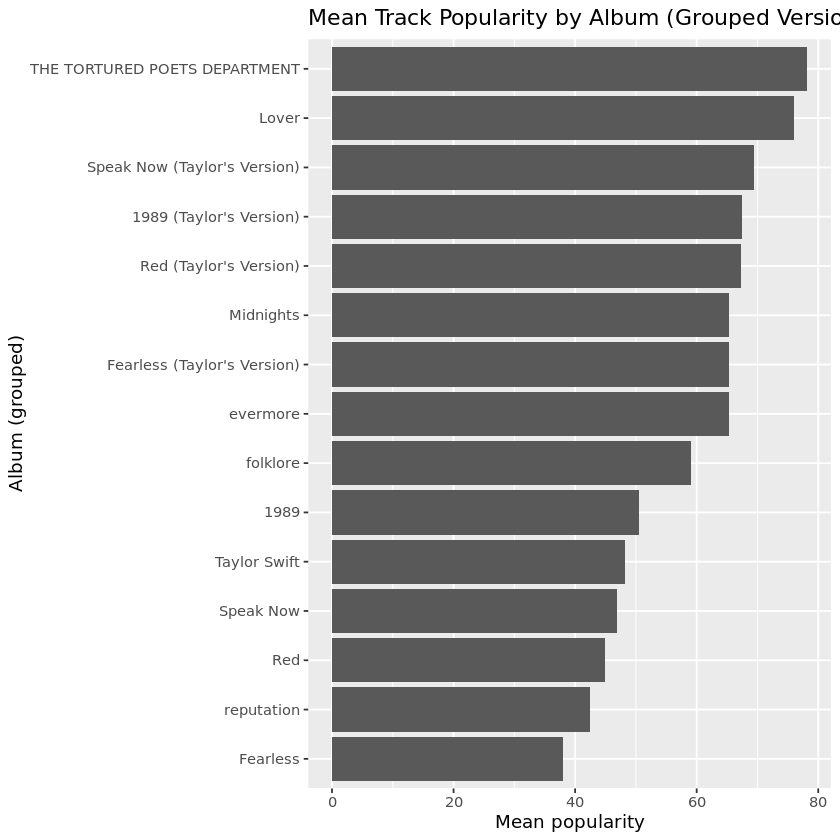

In [32]:
# album-popularity-plot 

album_pop |>
  slice_max(mean_popularity, n = 15) |>
  mutate(album_group = fct_reorder(album_group, mean_popularity)) |>
  ggplot(aes(x = album_group, y = mean_popularity)) +
  geom_col() +
  coord_flip() +
  labs(
    title = "Mean Track Popularity by Album (Grouped Versions)",
    x = "Album (grouped)",
    y = "Mean popularity"
  )

# Compares average popularity across albums after grouping versions. Recent eras and Taylor’s Version albums (TTPD, Lover, 1989 TV, Speak Now TV, Red TV, Fearless TV, Midnights, evermore) sit at the top, while original versions of older albums (Red, Speak Now, Fearless, and reputation) have noticeably lower mean popularity.


In [33]:
# feature-differences-by-pop-group 

pop_feature_summary <- ts |>
  filter(pop_group != "medium") |>
  group_by(pop_group) |>
  summarise(
    across(all_of(audio_vars), mean, na.rm = TRUE),
    mean_popularity = mean(popularity, na.rm = TRUE),
    .groups = "drop"
  )

pop_feature_summary


Warning message:
“There was 1 warning in `summarise()`.
ℹ In argument: `across(all_of(audio_vars), mean, na.rm = TRUE)`.
ℹ In group 1: `pop_group = low`.
Caused by warning:
! The `...` argument of `across()` is deprecated as of dplyr 1.1.0.
Supply arguments directly to `.fns` through an anonymous function instead.

  # Previously
  across(a:b, mean, na.rm = TRUE)

  # Now
  across(a:b, \(x) mean(x, na.rm = TRUE))”


pop_group,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,mean_popularity
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
low,0.2408270,0.5807075,0.6104150,0.0007399569,0.2100823,-6.620653,0.05184626,122.9246,0.4150476,35.23129
high,0.3343337,0.5916824,0.5524324,0.0026843489,0.1429480,-8.052730,0.06823986,122.1354,0.3689872,76.44595


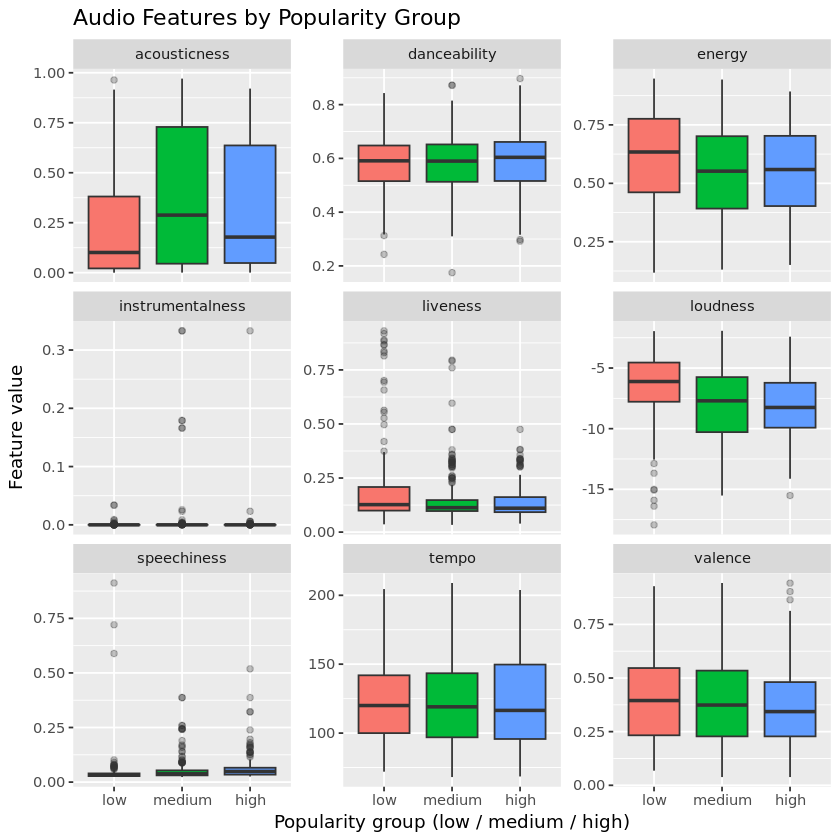

In [34]:
# feature-boxplots-by-pop-group 

ts |>
  pivot_longer(
    cols = all_of(audio_vars),
    names_to = "feature",
    values_to = "value"
  ) |>
  ggplot(aes(x = pop_group, y = value, fill = pop_group)) +
  geom_boxplot(outlier.alpha = 0.3) +
  facet_wrap(~ feature, scales = "free_y") +
  labs(
    title = "Audio Features by Popularity Group",
    x = "Popularity group (low / medium / high)",
    y = "Feature value"
  ) +
  guides(fill = "none")

# Boxplots of audio features for low, medium, and high popularity songs. Low-pop songs tend to be louder, higher-energy, more “live,” and slightly happier (higher valence), while high-pop songs are somewhat more acoustic, softer, and less live-sounding; medium songs fall in between, suggesting her most popular tracks lean toward a more polished, less concert-like sound.

In [35]:
# black-white-vs-color-summary 

bw_summary <- ts |>
  group_by(bw_album) |>
  summarise(
    n_tracks = n(),
    mean_popularity = mean(popularity, na.rm = TRUE),
    median_popularity = median(popularity, na.rm = TRUE),
    across(all_of(audio_vars), mean, na.rm = TRUE),
    .groups = "drop"
  )

bw_summary


bw_album,n_tracks,mean_popularity,median_popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
color,407,57.63145,61,0.2676495,0.5864054,0.5958796,0.004670922,0.1714602,-7.199052,0.05921572,122.9993,0.4035184
black_white,175,58.38286,65,0.4856004,0.5677771,0.4959486,0.000421789,0.1371063,-8.738640,0.05010171,121.0028,0.3618857


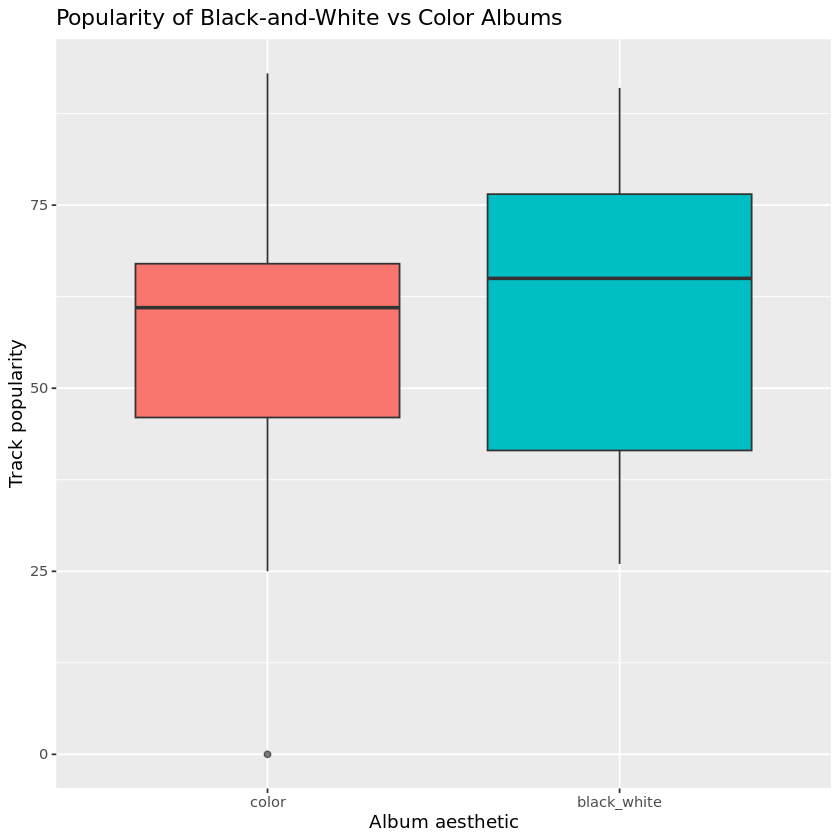

In [36]:
# black-white-vs-color-popularity 

ts |>
  ggplot(aes(x = bw_album, y = popularity, fill = bw_album)) +
  geom_boxplot(outlier.alpha = 0.3) +
  labs(
    title = "Popularity of Black-and-White vs Color Albums",
    x = "Album aesthetic",
    y = "Track popularity"
  ) +
  guides(fill = "none")

# Compares popularity for tracks from black‑and‑white aesthetic albums (folklore, reputation, TTPD) vs color albums. Black‑and‑white albums are a bit more acoustic and lower-energy and have slightly higher median popularity, but the popularity gap is modest, indicating a clear sonic shift with only a mild advantage in popularity.

In [37]:
# prepare-audio-matrix 

ts_audio <- ts |>
  select(all_of(audio_vars))

ts_audio_scaled <- ts_audio |>
  mutate(across(everything(), ~ as.numeric(scale(.x))))

X_audio <- as.matrix(ts_audio_scaled)

In [38]:
# pca-and-kmeans 

set.seed(123)

audio_pca <- prcomp(X_audio, center = FALSE, scale. = FALSE)

pca_scores <- as_tibble(audio_pca$x[, 1:2]) |>
  rename(PC1 = PC1, PC2 = PC2)

ts_pca <- ts |>
  bind_cols(pca_scores)

k <- 3
kmod <- kmeans(pca_scores, centers = k, nstart = 20)

ts_pca <- ts_pca |>
  mutate(cluster = factor(kmod$cluster))


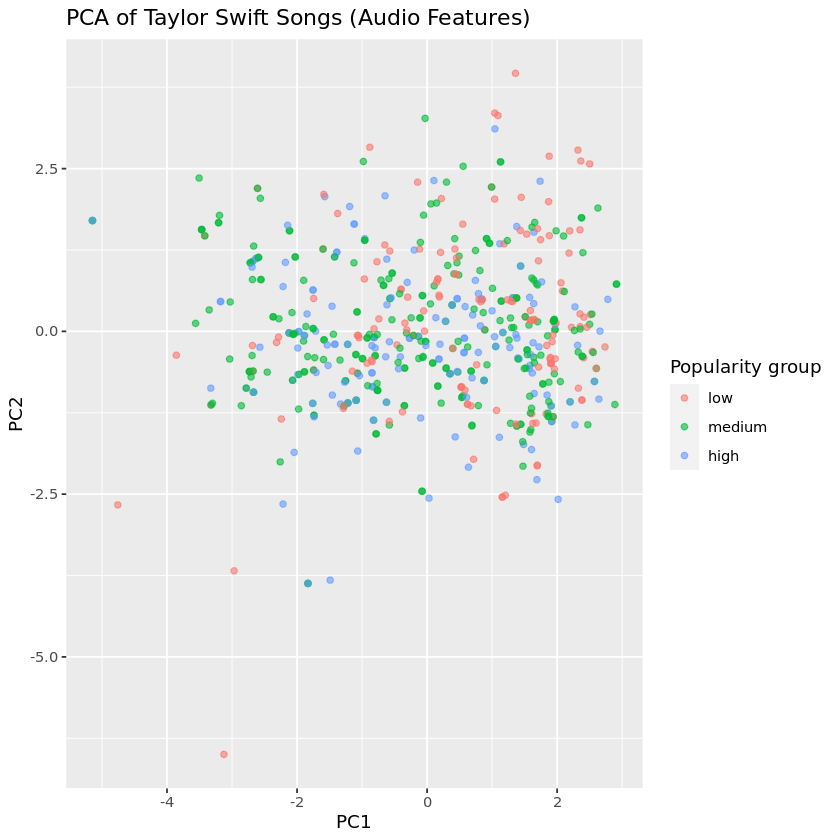

In [39]:
# pca-plot-by-pop-group 

ts_pca |>
  ggplot(aes(x = PC1, y = PC2, color = pop_group)) +
  geom_point(alpha = 0.6) +
  labs(
    title = "PCA of Taylor Swift Songs (Audio Features)",
    x = "PC1",
    y = "PC2",
    color = "Popularity group"
  )

# Reduces the nine audio features to two principal components. Low-popularity songs cluster toward a region corresponding to louder, more energetic tracks, whereas high-popularity songs shift toward the more acoustic/softer and slightly more danceable area, showing that popularity is linked to broad sonic style rather than a single feature.

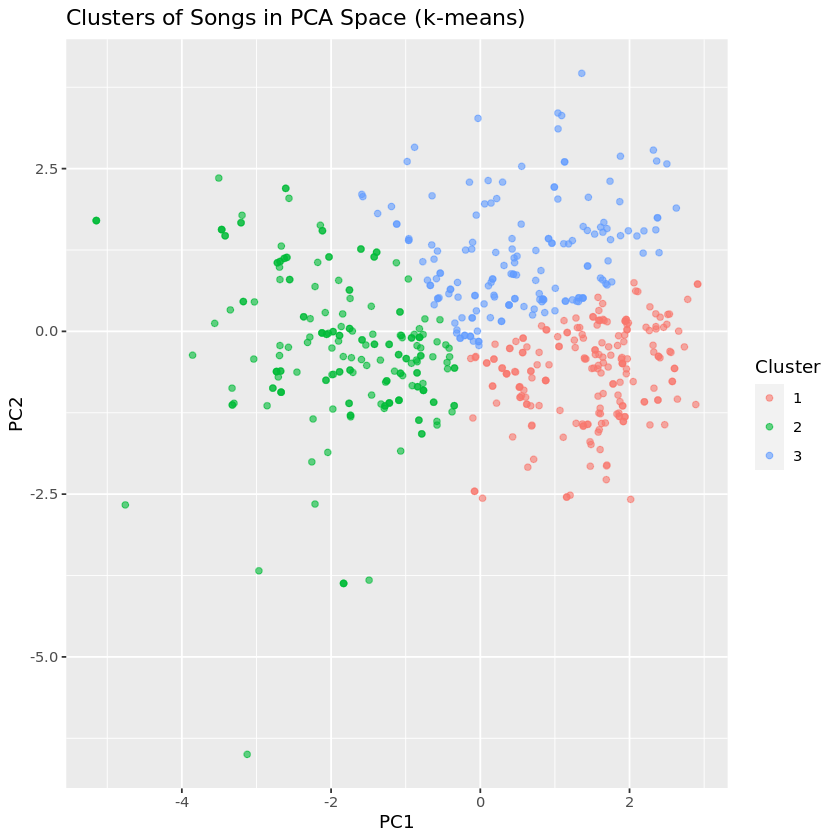

In [40]:
# pca-plot-by-cluster 
ts_pca |>
  ggplot(aes(x = PC1, y = PC2, color = cluster)) +
  geom_point(alpha = 0.6) +
  labs(
    title = "Clusters of Songs in PCA Space (k-means)",
    x = "PC1",
    y = "PC2",
    color = "Cluster"
  )

# Shows the same PCA space colored by unsupervised clusters. The algorithm finds groups roughly corresponding to (1) bright, high-energy dance‑leaning tracks, (2) softer acoustic/low‑energy tracks, and (3) more live/fast songs; average popularity differs only moderately, with the acoustic cluster slightly ahead, suggesting multiple sonic “styles” can succeed.

In [41]:
# train-test-split-for-regression

set.seed(123)

n <- nrow(ts)
train_idx <- sample.int(n, size = floor(0.7 * n))

X_train <- X_audio[train_idx, ]
X_test  <- X_audio[-train_idx, ]

y_train <- ts$popularity[train_idx]
y_test  <- ts$popularity[-train_idx]


In [42]:
# glmnet-lasso-regression 
set.seed(123)

cv_fit <- cv.glmnet(
  x = X_train,
  y = y_train,
  alpha = 1,
  family = "gaussian"
)

best_lambda <- cv_fit$lambda.min
best_lambda

lasso_fit <- glmnet(
  x = X_train,
  y = y_train,
  alpha = 1,
  lambda = best_lambda,
  family = "gaussian"
)

coef(lasso_fit)


[1] 0.4809485

10 x 1 sparse Matrix of class "dgCMatrix"
                         s0
(Intercept)      57.7117706
acousticness      .        
danceability      .        
energy            .        
instrumentalness  .        
liveness         -2.2158903
loudness         -1.7960220
speechiness      -1.0442038
tempo             .        
valence          -0.6685738

[1] 0.06464302

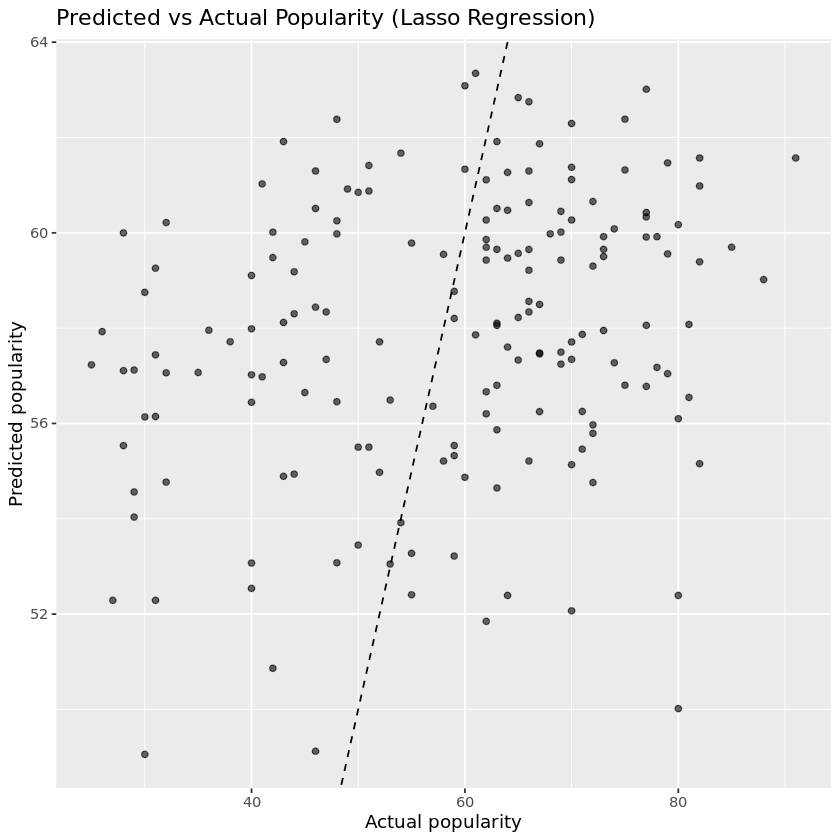

In [43]:
# glmnet-evaluation-and-plot 
y_pred <- predict(lasso_fit, newx = X_test, s = best_lambda)[, 1]

r2 <- cor(y_test, y_pred)^2
r2

tibble(
  actual = y_test,
  predicted = y_pred
) |>
  ggplot(aes(x = actual, y = predicted)) +
  geom_point(alpha = 0.6) +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed") +
  labs(
    title = "Predicted vs Actual Popularity (Lasso Regression)",
    x = "Actual popularity",
    y = "Predicted popularity"
  )

# Plots model predictions vs true popularity. Points are widely scattered around the diagonal, indicating that audio features alone capture only a small part of the variation in popularity; non‑audio factors (era, marketing, playlisting, fandom, etc.) likely play a large role.

In [44]:
# tv-vs-original-summary 
library(stringr)

tv_pairs <- ts |>
  filter(album_group %in% c(
    "Fearless", "Fearless (Taylor's Version)",
    "Speak Now", "Speak Now (Taylor's Version)",
    "Red", "Red (Taylor's Version)",
    "1989", "1989 (Taylor's Version)"
  )) |>
  mutate(
    base_era = case_when(
      str_detect(album_group, "Fearless") ~ "Fearless",
      str_detect(album_group, "Speak Now") ~ "Speak Now",
      str_detect(album_group, "Red") ~ "Red",
      str_detect(album_group, "1989") ~ "1989",
      TRUE ~ NA_character_
    ),
    base_era = factor(base_era, levels = c("Fearless", "Speak Now", "Red", "1989")),
    tv_flag = if_else(
      str_detect(album_group, "Taylor's Version"),
      "Taylor's Version",
      "Original"
    )
  )

tv_summary <- tv_pairs |>
  group_by(base_era, tv_flag) |>
  summarise(
    n_tracks = n(),
    mean_popularity = mean(popularity, na.rm = TRUE),
    median_popularity = median(popularity, na.rm = TRUE),
    .groups = "drop"
  )

tv_summary


base_era,tv_flag,n_tracks,mean_popularity,median_popularity
<fct>,<chr>,<int>,<dbl>,<dbl>
Fearless,Original,35,38.05714,39.0
Fearless,Taylor's Version,26,65.26923,63.0
Speak Now,Original,52,46.82692,46.0
Speak Now,Taylor's Version,22,69.45455,69.0
Red,Original,38,44.97368,42.0
Red,Taylor's Version,30,67.23333,66.0
1989,Original,32,50.50000,52.5
1989,Taylor's Version,43,67.48837,66.0


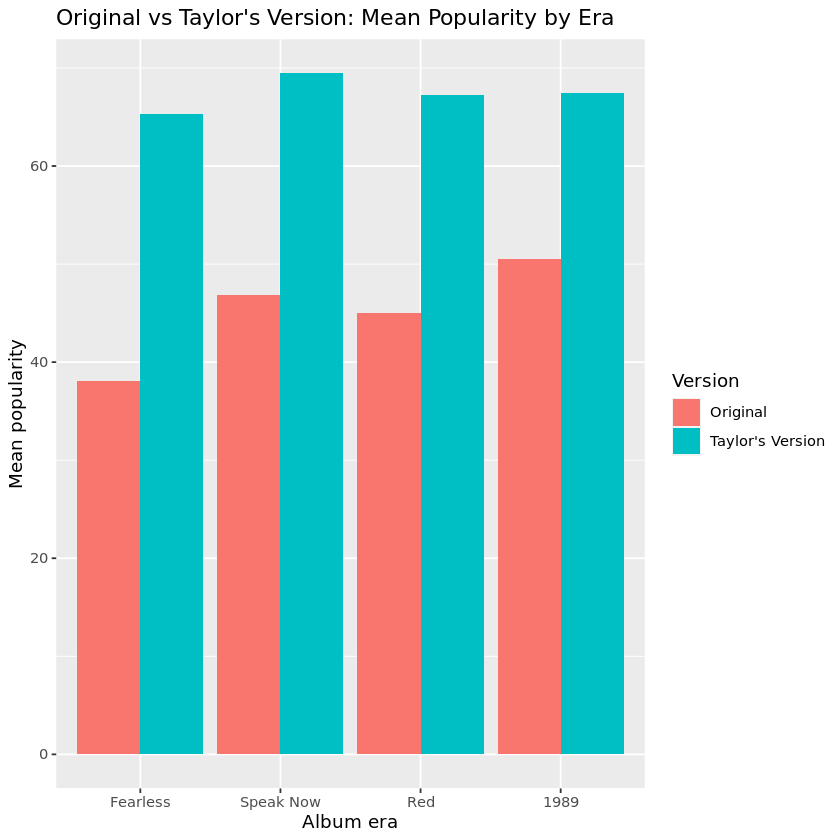

In [45]:
# tv-vs-original-popularity 
tv_summary |>
  ggplot(aes(x = base_era, y = mean_popularity, fill = tv_flag)) +
  geom_col(position = "dodge") +
  labs(
    title = "Original vs Taylor's Version: Mean Popularity by Era",
    x = "Album era",
    y = "Mean popularity",
    fill = "Version"
  )

# for all four eras (Fearless, Speak Now, Red, 1989), the Taylor’s Version releases have substantially higher mean popularity than the original albums, so the re‑recordings are doing better on Spotify in this dataset.

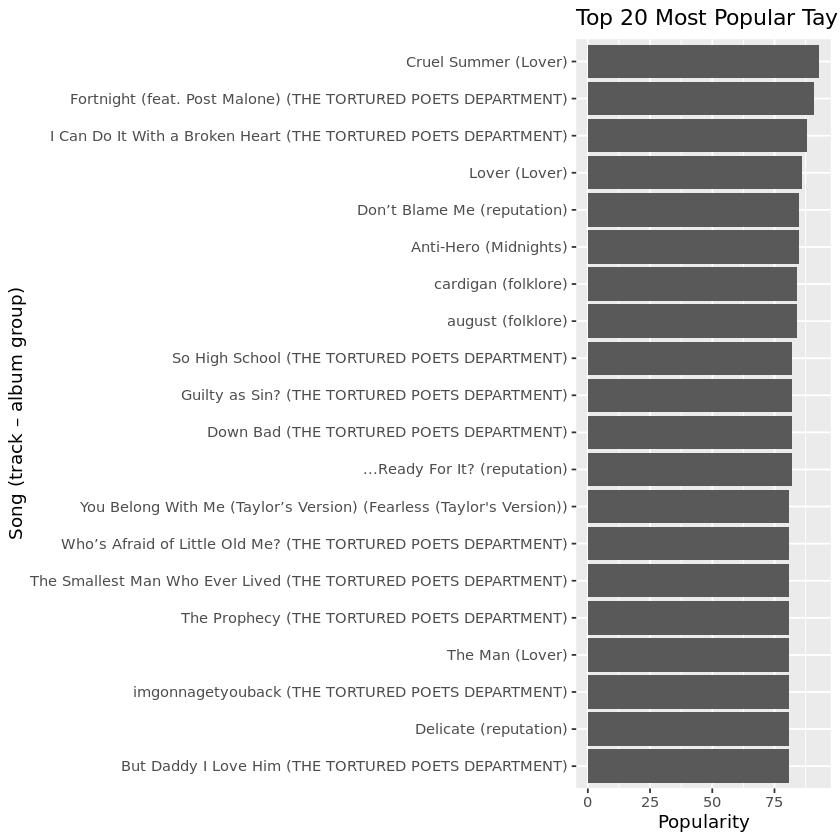

In [46]:
# top-20-most-popular-songs 
top20 <- ts |>
  arrange(desc(popularity)) |>
  distinct(track_name, album_group, .keep_all = TRUE) |>
  slice_head(n = 20) |>
  mutate(
    track_label = paste0(track_name, " (", album_group, ")"),
    track_label = fct_reorder(track_label, popularity)
  )

top20 |>
  ggplot(aes(x = track_label, y = popularity)) +
  geom_col() +
  coord_flip() +
  labs(
    title = "Top 20 Most Popular Taylor Swift Songs in This Dataset",
    x = "Song (track – album group)",
    y = "Popularity"
  )


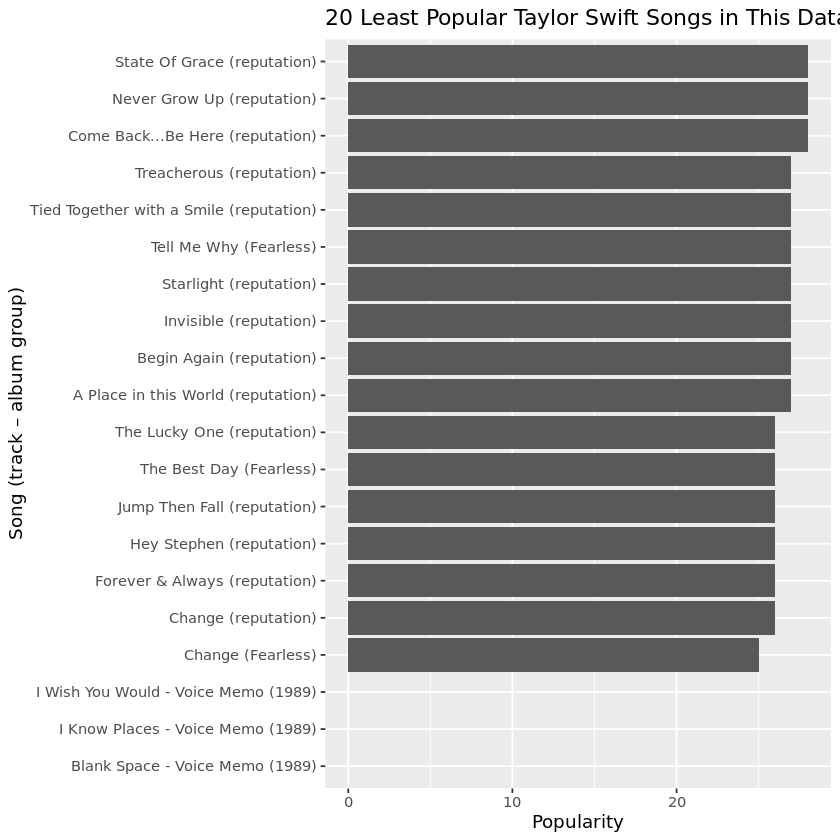

In [47]:
# bottom-20-least-popular-songs 

bottom20 <- ts |>
  arrange(popularity) |>
  distinct(track_name, album_group, .keep_all = TRUE) |>
  slice_head(n = 20) |>
  mutate(
    track_label = paste0(track_name, " (", album_group, ")"),
    track_label = fct_reorder(track_label, popularity)
  )

bottom20 |>
  ggplot(aes(x = track_label, y = popularity)) +
  geom_col() +
  coord_flip() +
  labs(
    title = "20 Least Popular Taylor Swift Songs in This Dataset",
    x = "Song (track – album group)",
    y = "Popularity"
  )

# as this displays the 20 least popular songs, and i have background info, i can infer that duplicates of songs on spotify do not receive significant stream numbers, 